# Covid-19 SEIR model for Belo Horizonte
(SEIR) Susceptible - Exposed - Infected - Recovered

In [1]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

In [2]:
from readData import read_data
from graphs.plot_graphs import plot_graph
from brasil.covid_brasil import *
from belo_horizonte.covid_bh import *
import pandas as pd
import plotly.offline as py
import plotly.graph_objs as go

In [3]:
df_srag = read_data('INFLUD-08-02-2021.csv')

## LMFIT (A python tool for model fitting)

In [4]:
%%capture
import sys
!{sys.executable} -m pip install lmfit

In [5]:
%%capture
!{sys.executable} -m pip install matplotlib

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters, report_fit
from scipy.integrate import odeint
from model_seir.params import create_params
from model_seir.run_model import run_model
from model_seir.residual import get_residual
from model_seir.derivative import deriv

## Model fitting: infected population

In [7]:
incubation_time = 5.0      # Incubation period of five days (1 to 12 days, but 5 days on average)
infective_time = 3.0                 # Infectious period may start 1 to 3 days before you develop symptoms
gamma = 1.0 / infective_time         # Recovery rate
delta = 1.0 / incubation_time        # Incubation period
R_0 = 4.0                            # Basic reproductive number
beta = R_0 * gamma                   # Infection rate: R_0 = beta / gamma, so beta = R_0 * gamma

N = 2_722_000                        # Belo Horizonte population

S0, E0, I0, R0 = N-1, 1, 0, 0    # initial conditions: one hundred exposed

In [8]:
# tuple -> (<value>, <vary>)
params = create_params(
    (S0, False), (E0, False), (I0, False), (R0, False), (N, False), 
    (beta, True), (gamma, True), (delta, False)
    )

In [9]:
df_bh_infected = infected_population_covid_bh(df_srag)

In [10]:
plot_graph(df_bh_infected, 'DT_SIN_PRI', 'SUM', 'Data do início dos sintomas x Confirmação diagnóstico Covid-19 em BH', 'Data dos primeiros sintomas', 'Número de pacientes confirmados com Covid-19')

In [11]:
data = df_bh_infected['SUM'][:220]       # Belo Horizonte
days = len(data.index)
x = np.linspace(0, days-1, days)[:220]

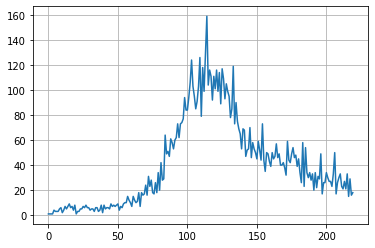

In [12]:
plt.plot(x, data)
plt.grid('True')

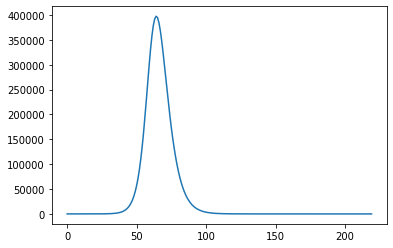

In [13]:
dS, dE, dI, dR = run_model(params, x)
plt.plot(dI)

In [14]:
out = minimize(get_residual, params, args=(data, x))

In [15]:
out.params

name,value,standard error,relative error,initial value,min,max,vary
S0,2721999.00,0.00000000,(0.00%),2721999,-inf,inf,False
E0,1.00000000,0.00000000,(0.00%),1,-inf,inf,False
I0,0.00000000,0.00000000,,0,-inf,inf,False
R0,0.00000000,0.00000000,,0,-inf,inf,False
N,2722000.00,0.00000000,(0.00%),2722000,-inf,inf,False
beta,504.568460,5.30120555,(1.05%),1.3333333333333333,-inf,inf,True
gamma,316.522386,3.11082965,(0.98%),0.3333333333333333,-inf,inf,True
delta,0.20000000,0.00000000,(0.00%),0.2,-inf,inf,False


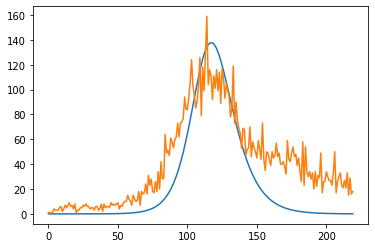

In [16]:
dS, dE, dI, dR = run_model(out.params, x)
plt.plot(dI)
plt.plot(data)

In [17]:
report_fit(out)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 117
    # data points      = 220
    # variables        = 2
    chi-square         = 131926.937
    reduced chi-square = 605.169434
    Akaike info crit   = 1411.20272
    Bayesian info crit = 1417.98997
[[Variables]]
    S0:     2721999 (fixed)
    E0:     1 (fixed)
    I0:     0 (fixed)
    R0:     0 (fixed)
    N:      2722000 (fixed)
    beta:   504.568460 +/- 5.30120555 (1.05%) (init = 1.333333)
    gamma:  316.522386 +/- 3.11082965 (0.98%) (init = 0.3333333)
    delta:  0.2 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma) =  0.962


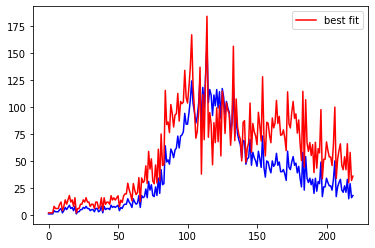

In [18]:
plt.plot(x, data, 'b')
plt.plot(x, get_residual(out.params, data, x) + data, 'r', label='best fit')
plt.legend(loc='best')
plt.show()

In [19]:
S0 = out.params['S0'].value
E0 = out.params['E0'].value
I0 = out.params['I0'].value
R0 = out.params['R0'].value
N = out.params['N'].value
beta = out.params['beta'].value
gamma = out.params['gamma'].value
delta = out.params['delta'].value

y0 = S0, E0, I0, R0

ret = odeint(deriv, y0, x, args=(N, beta, gamma, delta))
dS, dE, dI, dR = ret.T

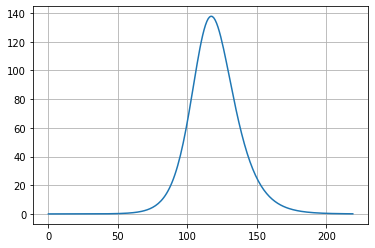

In [20]:
plt.plot(x, dI)
plt.grid('True')

## Model fitting: UTI(ICU) Covid-19 patients

In [21]:
incubation_time = 5.0      # Incubation period of five days (1 to 12 days, but 5 days on average)
infective_time = 3.0                 # Infectious period may start 1 to 3 days before you develop symptoms
gamma = 1.0 / infective_time         # Recovery rate
delta = 1.0 / incubation_time        # Incubation period
R_0 = 4.0                            # Basic reproductive number
beta = R_0 * gamma                   # Infection rate: R_0 = beta / gamma, so beta = R_0 * gamma

N = 2_722_000                        # Belo Horizonte population

S0, E0, I0, R0 = N-1, 1, 0, 0    # initial conditions: one hundred exposed

In [22]:
# tuple -> (<value>, <vary>)
params = create_params(
    (S0, False), (E0, False), (I0, False), (R0, False), (N, False), 
    (beta, True), (gamma, True), (delta, False)
    )

In [23]:
df_bh_uti = uti_data_covid_bh(df_srag)

In [24]:
plot_graph(df_bh_uti, 'DT_ENTUTI', 'SUM', 'Soma de Pessoas que deram entrada em UTI por data na rede SUS de Belo Horizonte', 'Data de entrada na UTI', 'Número de entradas de pacientes em UTI')

In [25]:
data = df_bh_uti['SUM'][:220]       # Belo Horizonte
days = len(data.index)
x = np.linspace(0, days-1, days)[:220]

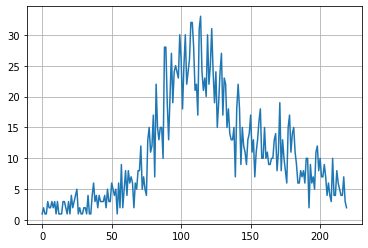

In [26]:
plt.plot(x, data)
plt.grid('True')

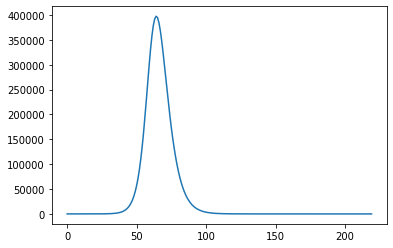

In [27]:
dS, dE, dI, dR = run_model(params, x)
plt.plot(dI)

In [28]:
out = minimize(get_residual, params, args=(data, x))

In [29]:
out.params

name,value,standard error,relative error,initial value,min,max,vary
S0,2721999.00,0.00000000,(0.00%),2721999,-inf,inf,False
E0,1.00000000,0.00000000,(0.00%),1,-inf,inf,False
I0,0.00000000,0.00000000,,0,-inf,inf,False
R0,0.00000000,0.00000000,,0,-inf,inf,False
N,2722000.00,0.00000000,(0.00%),2722000,-inf,inf,False
beta,2243.44515,101.213120,(4.51%),1.3333333333333333,-inf,inf,True
gamma,1377.06979,60.8340839,(4.42%),0.3333333333333333,-inf,inf,True
delta,0.20000000,0.00000000,(0.00%),0.2,-inf,inf,False


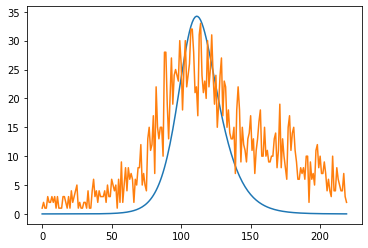

In [30]:
dS, dE, dI, dR = run_model(out.params, x)
plt.plot(dI)
plt.plot(data)

In [31]:
report_fit(out)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 142
    # data points      = 220
    # variables        = 2
    chi-square         = 12374.6226
    reduced chi-square = 56.7643240
    Akaike info crit   = 890.550620
    Bayesian info crit = 897.337875
[[Variables]]
    S0:     2721999 (fixed)
    E0:     1 (fixed)
    I0:     0 (fixed)
    R0:     0 (fixed)
    N:      2722000 (fixed)
    beta:   2243.44515 +/- 101.213120 (4.51%) (init = 1.333333)
    gamma:  1377.06979 +/- 60.8340839 (4.42%) (init = 0.3333333)
    delta:  0.2 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma) =  0.997


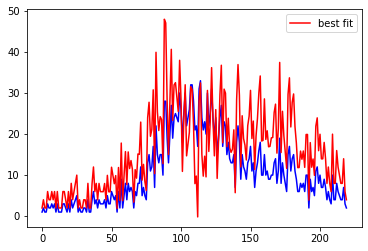

In [32]:
plt.plot(x, data, 'b')
plt.plot(x, get_residual(out.params, data, x) + data, 'r', label='best fit')
plt.legend(loc='best')
plt.show()

In [33]:
S0 = out.params['S0'].value
E0 = out.params['E0'].value
I0 = out.params['I0'].value
R0 = out.params['R0'].value
N = out.params['N'].value
beta = out.params['beta'].value
gamma = out.params['gamma'].value
delta = out.params['delta'].value

y0 = S0, E0, I0, R0

ret = odeint(deriv, y0, x, args=(N, beta, gamma, delta))
dS, dE, dI, dR = ret.T

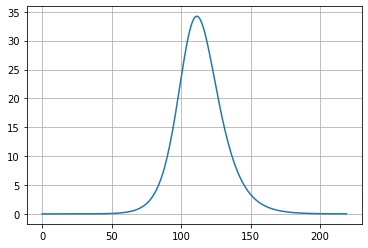

In [34]:
plt.plot(x, dI)
plt.grid('True')